# Gnocis - Supporting information
Bjørn André Bredesen, 2022

This notebook generates the supporting information figures for the manuscript. Note: Running this notebook currently requires a CUDA GPU but can be modified to work with a CPU (see tutorial).

-------------------------------------

## Data sources and references
 * ModENCODE: http://www.modencode.org/
    - Citation: https://www.nature.com/articles/459927a
 * Ensembl: ftp://ftp.ensembl.org/pub/release-100/gtf/drosophila_melanogaster/
    - Citation: https://doi.org/10.1093/nar/gkx1098
 * FlyBase: https://flybase.org/
    - Citation: https://academic.oup.com/nar/article/41/D1/D751/1051942
 * Kahn *et al.* 2014: https://doi.org/10.1371/journal.pgen.1004495.s010
    - Citation: https://doi.org/10.1371/journal.pgen.1004495
 * Enderle *et al.* 2011: Supplementary Table 3 (Supp Tabl 3.txt)
    - Citation: https://doi.org/10.1101/gr.114348.110
 * Bredesen *et al.* 2019: https://doi.org/10.1093/nar/gkz617
 * Ringrose *et al.* 2003: https://doi.org/10.1016/S1534-5807(03)00337-X

-------------------------------------

In [1]:
import gnocis as nc # Load Gnocis
seed = 12345
nc.setSeed(seed) # Set random seed

In [2]:
import os
import numpy as np
import gnocis.tfModels as tfnc
os.environ['PYTHONHASHSEED'] = str(seed)
tfnc.setSeed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
nc.setNCores(12) # Enable multi-core processing

In [4]:
import scipy.stats as st

alpha = 0.95

def confint(X):
    m = nc.mean(X)
    se = st.sem(X)
    if len(X) < 2 or se == 0.0: return 0.
    a, b = st.t.interval(alpha, len(X)-1, loc = m, scale = se)
    return b - m

nc.setConfidenceIntervalFunction(confint)

In [5]:
Dmel = nc.genome('D. melanogaster R5')\
    .streamFASTAGZ('DmelR5.fasta.gz')\
    .loadEnsemblAnnotationGTFGZ('./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz')

In [6]:
Kahn2014Rgn = nc.loadGFF('Kahn2014.GFF')
Kahn2014Rgn

0,2L,5290,6289,+,1000
1,2L,594635,595634,+,1000
2,2L,1643905,1644904,+,1000
3,2L,1972530,1973529,+,1000
4,2L,2448155,2449154,+,1000
...,...,...,...,...,...
196,X,17662071,17663070,+,1000
197,X,17683194,17684193,+,1000
198,X,17695903,17696902,+,1000
199,X,18260357,18261356,+,1000
200,X,21244791,21245790,+,1000


In [7]:
invectedProximal = Dmel \
                    .gene('inv') \
                    .region \
                    .singleton() \
                    .recenter(100000)

vestigialProximal = Dmel \
                    .gene('vg') \
                    .region \
                    .singleton() \
                    .recenter(100000)

Kahn2014Seq = Kahn2014Rgn \
               .nonOverlap(invectedProximal) \
               .nonOverlap(vestigialProximal) \
               .recenter(3000) \
               .extract(Dmel)

Kahn2014Seq

0,2L:4289..7288 (+),,3000,2L:4289..7288 (+),TATTCAAGTT...TTTCCGGCAAA
1,2L:593634..596633 (+),,3000,2L:593634..596633 (+),GCCAAGTGAC...AGCTCAAAAGA
2,2L:1642904..1645903 (+),,3000,2L:1642904..1645903 (+),TGCGGCGTTT...TTGAAGGTCCT
3,2L:1971529..1974528 (+),,3000,2L:1971529..1974528 (+),ACGGAGTCCA...TTCGTTACGTT
4,2L:2447154..2450153 (+),,3000,2L:2447154..2450153 (+),CCAGACCGAA...AACTGAACTTC
...,...,...,...,...,...
191,3R:2658822...6591228 (+),,3000,3R:2658822...6591228 (+),AAAGTCAACA...AAAAGAGGCCA
192,3R:2659713...6600136 (+),,3000,3R:2659713...6600136 (+),TGCGCGTGTT...AACTGCAACAG
193,3R:2660622...6609226 (+),,3000,3R:2660622...6609226 (+),TGGTCGCTAG...AAAACAAATAA
194,3R:2673673...6739736 (+),,3000,3R:2673673...6739736 (+),ATCGGAAAGT...ACTCGGATCCG
195,3R:2688682...6889821 (+),,3000,3R:2688682...6889821 (+),GTTTCAATTT...TCGGATTGGAT


In [8]:
MCPRE = nc.MarkovChain(trainingSequences = Kahn2014Seq,
                       degree = 4)

DummyPREs = MCPRE.generateSet(
    n = 100 * len(Kahn2014Seq),
    length = len(Kahn2014Seq[0]))

In [9]:
MCGenome = nc.MarkovChain(trainingSequences = Dmel,
                          degree = 4)

DummyGenomic = MCGenome.generateSet(
    n = 100 * len(Kahn2014Seq),
    length = len(Kahn2014Seq[0]))

In [10]:
CDSSeq = Dmel \
          .getCDS() \
          .flatten() \
          .extract(Dmel)

CDSFragments = nc.sequence('CDS',
                           ''.join(s.seq for s in CDSSeq))\
                 .windows(3000, 3000)

In [11]:
PcG = nc.biomarkers('PcG', [
    nc.loadGFFGZ('Pc.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('Psc.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('dRING.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('H3K27me3.gff3.gz'),
])

In [12]:
gwWin = Dmel.windowRegions(size = 3000, step = 250) \
            .filter('', lambda r: r.seq in [ '2L', '2R', '3L', '3R', '4', 'X' ])

gwWinNonPcG = PcG.LBMEs(gwWin, threshold = 0) \
                 .nonOverlap(invectedProximal) \
                 .nonOverlap(vestigialProximal)

gwWinNonPcGSeq = gwWinNonPcG.extract(Dmel) \
                            .windows(size = 3000, step = 3000) # PcG.LBMEs merges overlapping windows,
                                                               # so get non-overlapping 3kb windows

gwWinNonPcGSeq

0,2L:0..3999...0..2999 (+),,3000,2L:0..3999...0..2999 (+),CGACAATGCA...AGAGTAGTGCC
1,2L:13750.....0..2999 (+),,3000,2L:13750.....0..2999 (+),CCCTCAATGA...TTTTTATGCGG
2,2L:13750.....0..5999 (+),,3000,2L:13750.....0..5999 (+),TGCTTTGTGG...ATTATAAGCTT
3,2L:23250.....0..2999 (+),,3000,2L:23250.....0..2999 (+),CAATTACCCA...AATGTATCGTA
4,2L:23250.....0..5999 (+),,3000,2L:23250.....0..5999 (+),AATATCTATA...TTAGTAATCAT
...,...,...,...,...,...
29426,3R:2784300.....35999 (+),,3000,3R:2784300.....35999 (+),AATCGTTTCT...TTGACGACGAG
29427,3R:2784300.....38999 (+),,3000,3R:2784300.....38999 (+),GCTGAGGAAG...TTCCACATTAT
29428,3R:2784300.....41999 (+),,3000,3R:2784300.....41999 (+),TAAATTTATA...AATCATGAATG
29429,3R:2784300.....44999 (+),,3000,3R:2784300.....44999 (+),AAAATAAATT...GTAAATATGCC
29430,3R:2790075...0..2999 (+),,3000,3R:2790075...0..2999 (+),TGCCGGTGTA...ATCCTTCTGGA


In [13]:
motifs = nc.motifs('Ringrose et al. 2003 + GTGT', [
    nc.IUPACMotif('En', 'GSNMACGCCCC', 1),
    nc.IUPACMotif('G10', 'GAGAGAGAGA', 1),
    nc.IUPACMotif('GAF', 'GAGAG', 0),
    nc.IUPACMotif('PF', 'GCCATHWY', 0),
    nc.IUPACMotif('PM', 'CNGCCATNDNND', 0),
    nc.IUPACMotif('PS', 'GCCAT', 0),
    nc.IUPACMotif('Z', 'YGAGYG', 0),
    nc.IUPACMotif('GTGT', 'GTGT', 0)
])
motifs

0,En,IUPAC,GSNMACGCCCC,1
1,G10,IUPAC,GAGAGAGAGA,1
2,GAF,IUPAC,GAGAG,0
3,PF,IUPAC,GCCATHWY,0
4,PM,IUPAC,CNGCCATNDNND,0
5,PS,IUPAC,GCCAT,0
6,Z,IUPAC,YGAGYG,0
7,GTGT,IUPAC,GTGT,0


In [14]:
labelDummyGenomic = nc.sequenceLabel('Dummy genomic', -1)
labelDummyPRE = nc.sequenceLabel('Dummy PRE', -2)
labelCDS = nc.sequenceLabel('Coding sequences', -3)
labelNonPcG = nc.sequenceLabel('Non-PcG', -4)

trainingSet = Kahn2014Seq.label(nc.positive) \
    + DummyGenomic.label(labelDummyGenomic) \
    + DummyPREs.label(labelDummyPRE) \
    + CDSFragments.label(labelCDS) \
    + gwWinNonPcGSeq.label(labelNonPcG)

trainingSet

0,2L:4289..7288 (+),Positive,3000,2L:4289..7288 (+),TATTCAAGTT...TTTCCGGCAAA
1,2L:593634..596633 (+),Positive,3000,2L:593634..596633 (+),GCCAAGTGAC...AGCTCAAAAGA
2,2L:1642904..1645903 (+),Positive,3000,2L:1642904..1645903 (+),TGCGGCGTTT...TTGAAGGTCCT
3,2L:1971529..1974528 (+),Positive,3000,2L:1971529..1974528 (+),ACGGAGTCCA...TTCGTTACGTT
4,2L:2447154..2450153 (+),Positive,3000,2L:2447154..2450153 (+),CCAGACCGAA...AACTGAACTTC
...,...,...,...,...,...
76408,3R:2784300.....35999 (+),Non-PcG,3000,3R:2784300.....35999 (+),AATCGTTTCT...TTGACGACGAG
76409,3R:2784300.....38999 (+),Non-PcG,3000,3R:2784300.....38999 (+),GCTGAGGAAG...TTCCACATTAT
76410,3R:2784300.....41999 (+),Non-PcG,3000,3R:2784300.....41999 (+),TAAATTTATA...AATCATGAATG
76411,3R:2784300.....44999 (+),Non-PcG,3000,3R:2784300.....44999 (+),AAAATAAATT...GTAAATATGCC
76412,3R:2790075...0..2999 (+),Non-PcG,3000,3R:2790075...0..2999 (+),TGCCGGTGTA...ATCCTTCTGGA


In [15]:
PyPREdictor = motifs \
               .pairFreq(distCut = 219) \
               .model(nc.logOdds(
                      labelPositive = nc.positive,
                      labelNegative = labelDummyPRE)
               ) \
               .sequenceModel(name = 'PyPREdictor (M2003+GTGT)',
                              windowSize = 500, windowStep = 250)

In [16]:
DummyPREdictor = motifs \
               .pairFreq(distCut = 219) \
               .sum() \
               .sequenceModel(name = 'Dummy PREdictor (M2003+GTGT)',
                              windowSize = 500, windowStep = 250)

In [17]:
import gnocis.sklearnCUDAModels as sklcunc

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; S

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100
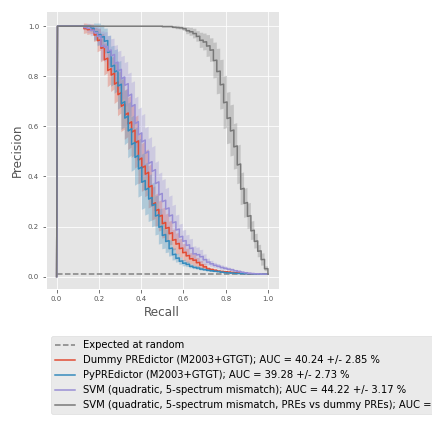
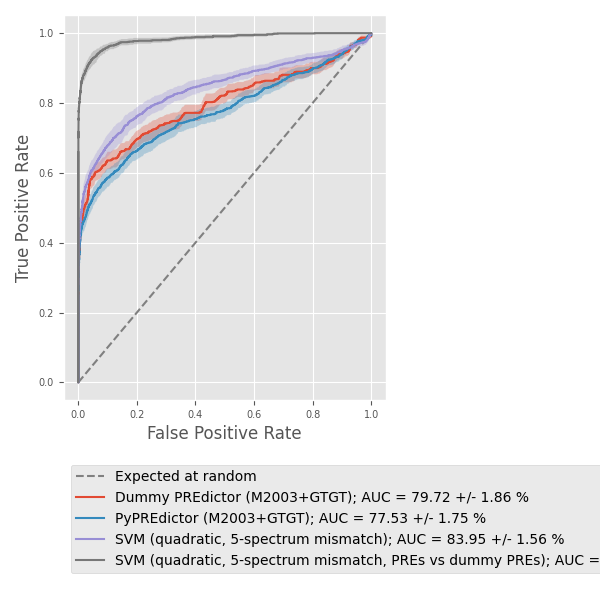

In [18]:
CV = nc.crossvalidate([
        DummyPREdictor,
        PyPREdictor,
        nc.kSpectrumMM(5)\
          .window(size = 500, step = 250)\
          .scale()\
          .model(sklcunc.CUDASVM(kDegree = 2, C = 1,
                                 labelPositive = nc.positive,
                                 labelNegative = labelNonPcG))\
          .sequenceModel(name = 'SVM (quadratic, 5-spectrum mismatch)'),
        nc.kSpectrumMM(5)\
          .window(size = 500, step = 250)\
          .scale()\
          .model(sklcunc.CUDASVM(kDegree = 2, C = 1,
                                 labelPositive = nc.positive,
                                 labelNegative = labelDummyPRE))\
          .sequenceModel(name = 'SVM (quadratic, 5-spectrum mismatch, PREs vs dummy PREs)')
    ],
    trainingSet = trainingSet,
    validationSet = Kahn2014Seq.label(nc.positive) + DummyPREs.label(nc.negative),
    ratioTrainTest = 0.6875, # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
    ratioNegPos = 100.)

CV

In [19]:
CV.plotPRC(outpath = './S1FigA.pdf', fontsizeAxis = 14, fontsizeLabels = 18, fontsizeLegend = 14)

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; S

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Training set:                                                                                                                                                                                                                                                                                                                                                                                                                     Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 831769172> + CDS windows(3000/3000) + Regions set: Windows (Window size: 3000 bp; step size: 250 bp) () (PcG LBME) not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.
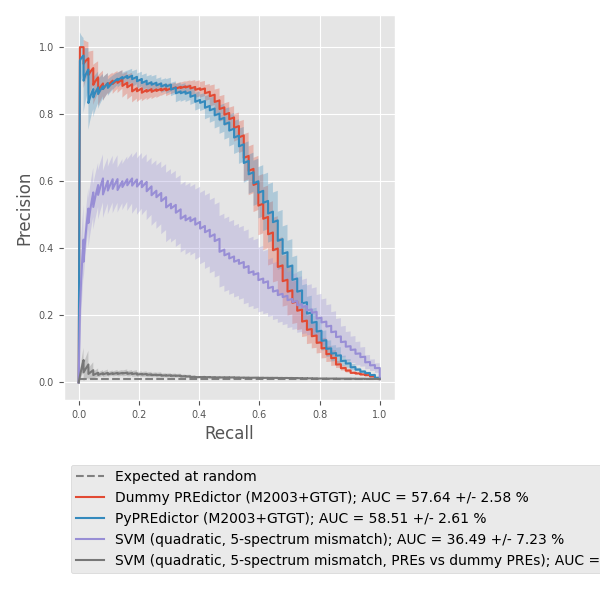
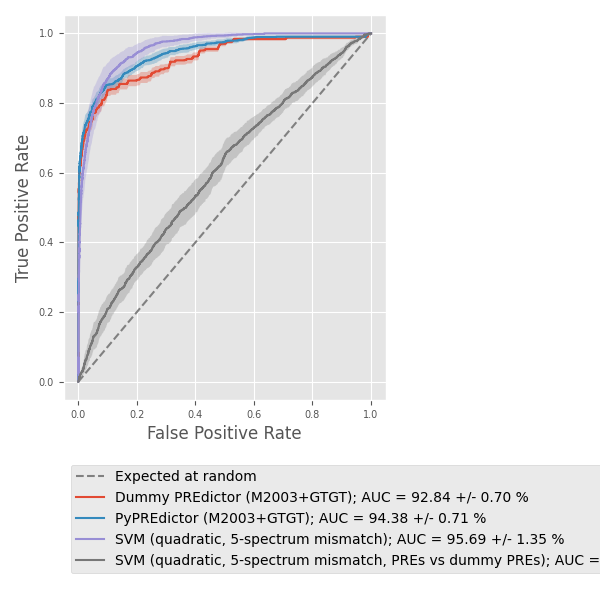

In [20]:
valSet = Kahn2014Seq.label(nc.positive) + CDSFragments.label(nc.negative)

CVPREvsCDS = nc.crossvalidate(
    CV.models,
    trainingSet = trainingSet,
    validationSet = valSet,
    ratioTrainTest = 0.6875) # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
CVPREvsCDS

In [21]:
CVPREvsCDS.plotPRC(outpath = './S1FigB.pdf', fontsizeAxis = 14, fontsizeLabels = 18, fontsizeLegend = 14)

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; S

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 831769172> + CDS
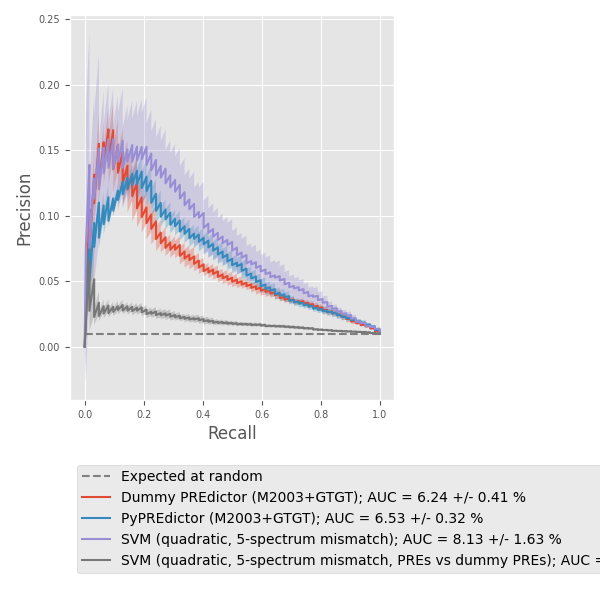
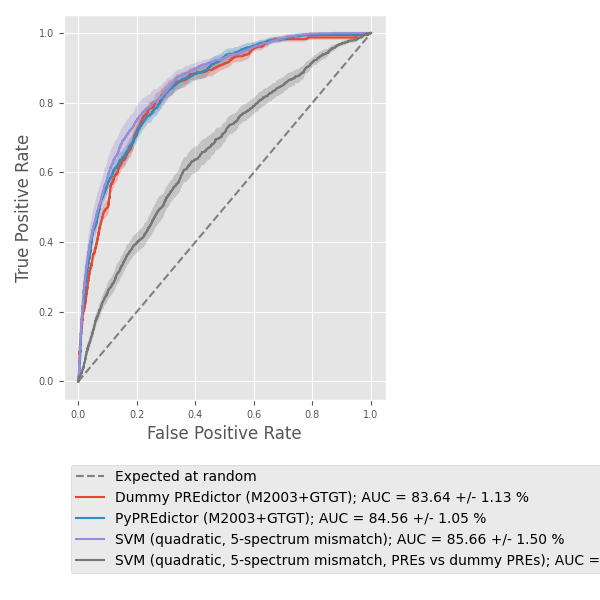

In [22]:
valSet = Kahn2014Seq.label(nc.positive) + gwWinNonPcGSeq.label(nc.negative)

CVPREvsNonPRE = nc.crossvalidate(
    CV.models,
    trainingSet = trainingSet,
    validationSet = valSet,
    ratioTrainTest = 0.6875) # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
CVPREvsNonPRE

In [23]:
CVPREvsNonPRE.plotPRC(outpath = './S1FigC.pdf', fontsizeAxis = 14, fontsizeLabels = 18, fontsizeLegend = 14)